In [1]:
import numpy as np
import torch
from torch import nn, utils

import matplotlib.pyplot as plt
import os

In [2]:
# download data
url = 'https://gitlab.com/yuxuan.chen/'\
    'storage/-/raw/master/DL-2020/week2/'\
    'prediction-challenge-01-data.npz'
!wget -nc $url

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# meaning of dimension of our data
# 1st index: image id-number
# 2nd index: color channel
# 3 & 4th index: pixel value
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)
print(test_x.shape, test_x.dtype)

File 'prediction-challenge-01-data.npz' already there; not retrieving.

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


In [3]:
# split the data into train and valid set: 16000 vs. 4000
train_size = 18000
train_x, val_x = data_x[:train_size, ], data_x[train_size:, ]
train_y, val_y = data_y[:train_size, ], data_y[train_size:, ]

# transform all our numpy arrays into torch tensors
train_x, train_y, val_x, val_y, test_x = map(
    torch.tensor, (train_x, train_y, val_x, val_y, test_x))

In [4]:
# hyper-parameters
input_size = 784
num_classes = 10
num_epochs = 200
batch_size = 256
learning_rate = 0.005
weight_decay = 0.01

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# create datasets and dataloaders from our newly partitioned data
train_dataset = utils.data.TensorDataset(train_x,train_y)
train_loader = utils.data.DataLoader(dataset=train_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     pin_memory=True)

In [6]:
# buld a model of logistic regression
model = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(input_size, num_classes)).to(device)

# set criterion and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=learning_rate, 
                            weight_decay=weight_decay) 

In [7]:
def accuracy(outputs, labels):
    assert outputs.size(0) == labels.size(0)

    _, pred = torch.max(outputs.data, 1)
    total = labels.size(0)
    hit = (pred == labels).sum()
            
    return 1.0 * hit / total

In [8]:
# train our model
best_val_acc = 0
for epoch in range(num_epochs):
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_acc = accuracy(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # each 10 epochs, 
    # print the loss and accuracy for the last batch of this epoch
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
            epoch + 1, num_epochs, loss.item()))

    # validate after each epoch
    with torch.no_grad():
        images, labels = val_x.to(device), val_y.to(device)
        outputs = model(images)
        val_acc = accuracy(outputs, labels)

        if (epoch + 1) % 10 == 0:
            print('Validation Accuracy: {:.3f}%'.format(100 * val_acc))
            print('=' * 50)
        
        # save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if best_val_acc > 0.9:
                torch.save(model, './saved_model.ckpt')
            
print('Best Valid Accuracy: {:.3f}%'.format(100 * best_val_acc))

Epoch [10/200], Training Loss: 103.3262
Validation Accuracy: 82.000%
Epoch [20/200], Training Loss: 65.6002
Validation Accuracy: 82.250%
Epoch [30/200], Training Loss: 114.8502
Validation Accuracy: 74.850%
Epoch [40/200], Training Loss: 8.9470
Validation Accuracy: 89.350%
Epoch [50/200], Training Loss: 25.0777
Validation Accuracy: 88.950%
Epoch [60/200], Training Loss: 32.4734
Validation Accuracy: 91.000%
Epoch [70/200], Training Loss: 16.1681
Validation Accuracy: 84.950%
Epoch [80/200], Training Loss: 104.6598
Validation Accuracy: 86.300%
Epoch [90/200], Training Loss: 33.5099
Validation Accuracy: 78.550%
Epoch [100/200], Training Loss: 64.2130
Validation Accuracy: 79.750%
Epoch [110/200], Training Loss: 16.4800
Validation Accuracy: 88.600%
Epoch [120/200], Training Loss: 62.2638
Validation Accuracy: 86.050%
Epoch [130/200], Training Loss: 8.8573
Validation Accuracy: 89.850%
Epoch [140/200], Training Loss: 10.9223
Validation Accuracy: 88.600%
Epoch [150/200], Training Loss: 22.3086
Va

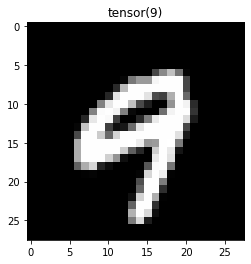

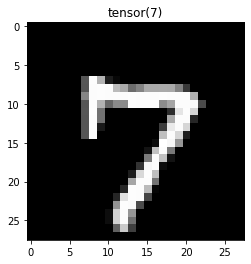

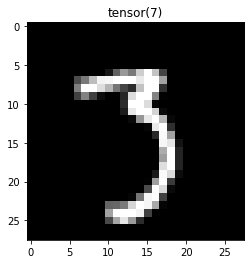

In [9]:
# load the saved model
saved_model = torch.load('./saved_model.ckpt').to(device)

# predict on test set with the saved model
with torch.no_grad():
    test_pred = saved_model(test_x.to(device))
    _, test_pred = torch.max(test_pred.data, 1)

# show some answers
for i in range(3):
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    plt.title(test_pred[i])
    plt.show()